In [1]:
import utils.eigenstate_generator as eig
import utils.cs_vqe as c
import utils.cs_vqe_ansatz as c_anz
import utils.qubit_conversion as qonvert
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state

In [2]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

speciesname = 'H2-O1_STO-3G_singlet'

encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
ham = hamiltonians[speciesname][2] # full Hamiltonian
ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian

print('number of qubits:', num_qubits)
print('true ground state energy:', true_gs)
print('noncontextual approximation to ground state energy:', gs_noncon[0])

number of qubits: 10
true ground state energy: -83.92870248174707
noncontextual approximation to ground state energy: -83.87422390061549


In [3]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}

In [4]:
print('commuting generators:',model[0], '\n')
print('anticommuting generators:',model[1], '\n')
print('Minimising configuration:', gs_noncon[1])

commuting generators: ['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'] 

anticommuting generators: ['IIIIZXZZZZ', 'IIIIIZIIII'] 

Minimising configuration: [[1, -1, -1, -1, -1, -1, -1, -1, -1], [9.576858245891391e-08, -0.9999999999999954]]


In [5]:
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
r1 = ep_state[1][0]
r2 = ep_state[1][1]
print('Observable A:', A)

Observable A: {'IIIIZXZZZZ': 9.576858245891391e-08, 'IIIIIZIIII': -0.9999999999999954}


In [6]:
c_anz.epistemic_dist(ep_state)

{(1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1): 1.1379787092233828e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1): 0.5000000478842901,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1): 1.137978491258188e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1): 0.49999995211570764}

In [7]:
generators = model[0]
print(generators)

['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ']


In [8]:
ham_q = qonvert.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically
psi = eig.add_eigenstate(molecule='H2O', r1=r1, r2=r2, index=495, theta=0, num_qubits=num_qubits)
expect = eig.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-83.87422390061549+0j)
Noncontextual approximation: -83.87422390061549
Expectation values match? True


In [10]:
qmap = eig.qubit_map('H2O', num_qubits)

In [13]:
qmap_expect=[]
for i in eig.find_eigenstate_indices('0111101111', [0,3,4]):
    psi = eig.add_eigenstate(molecule='H2O', r1=r1, r2=r2, index=i, theta=0, num_qubits=num_qubits)
    expect = eig.expectation(ham_q, psi, num_qubits)
    qmap_expect.append([expect, qmap[i]])

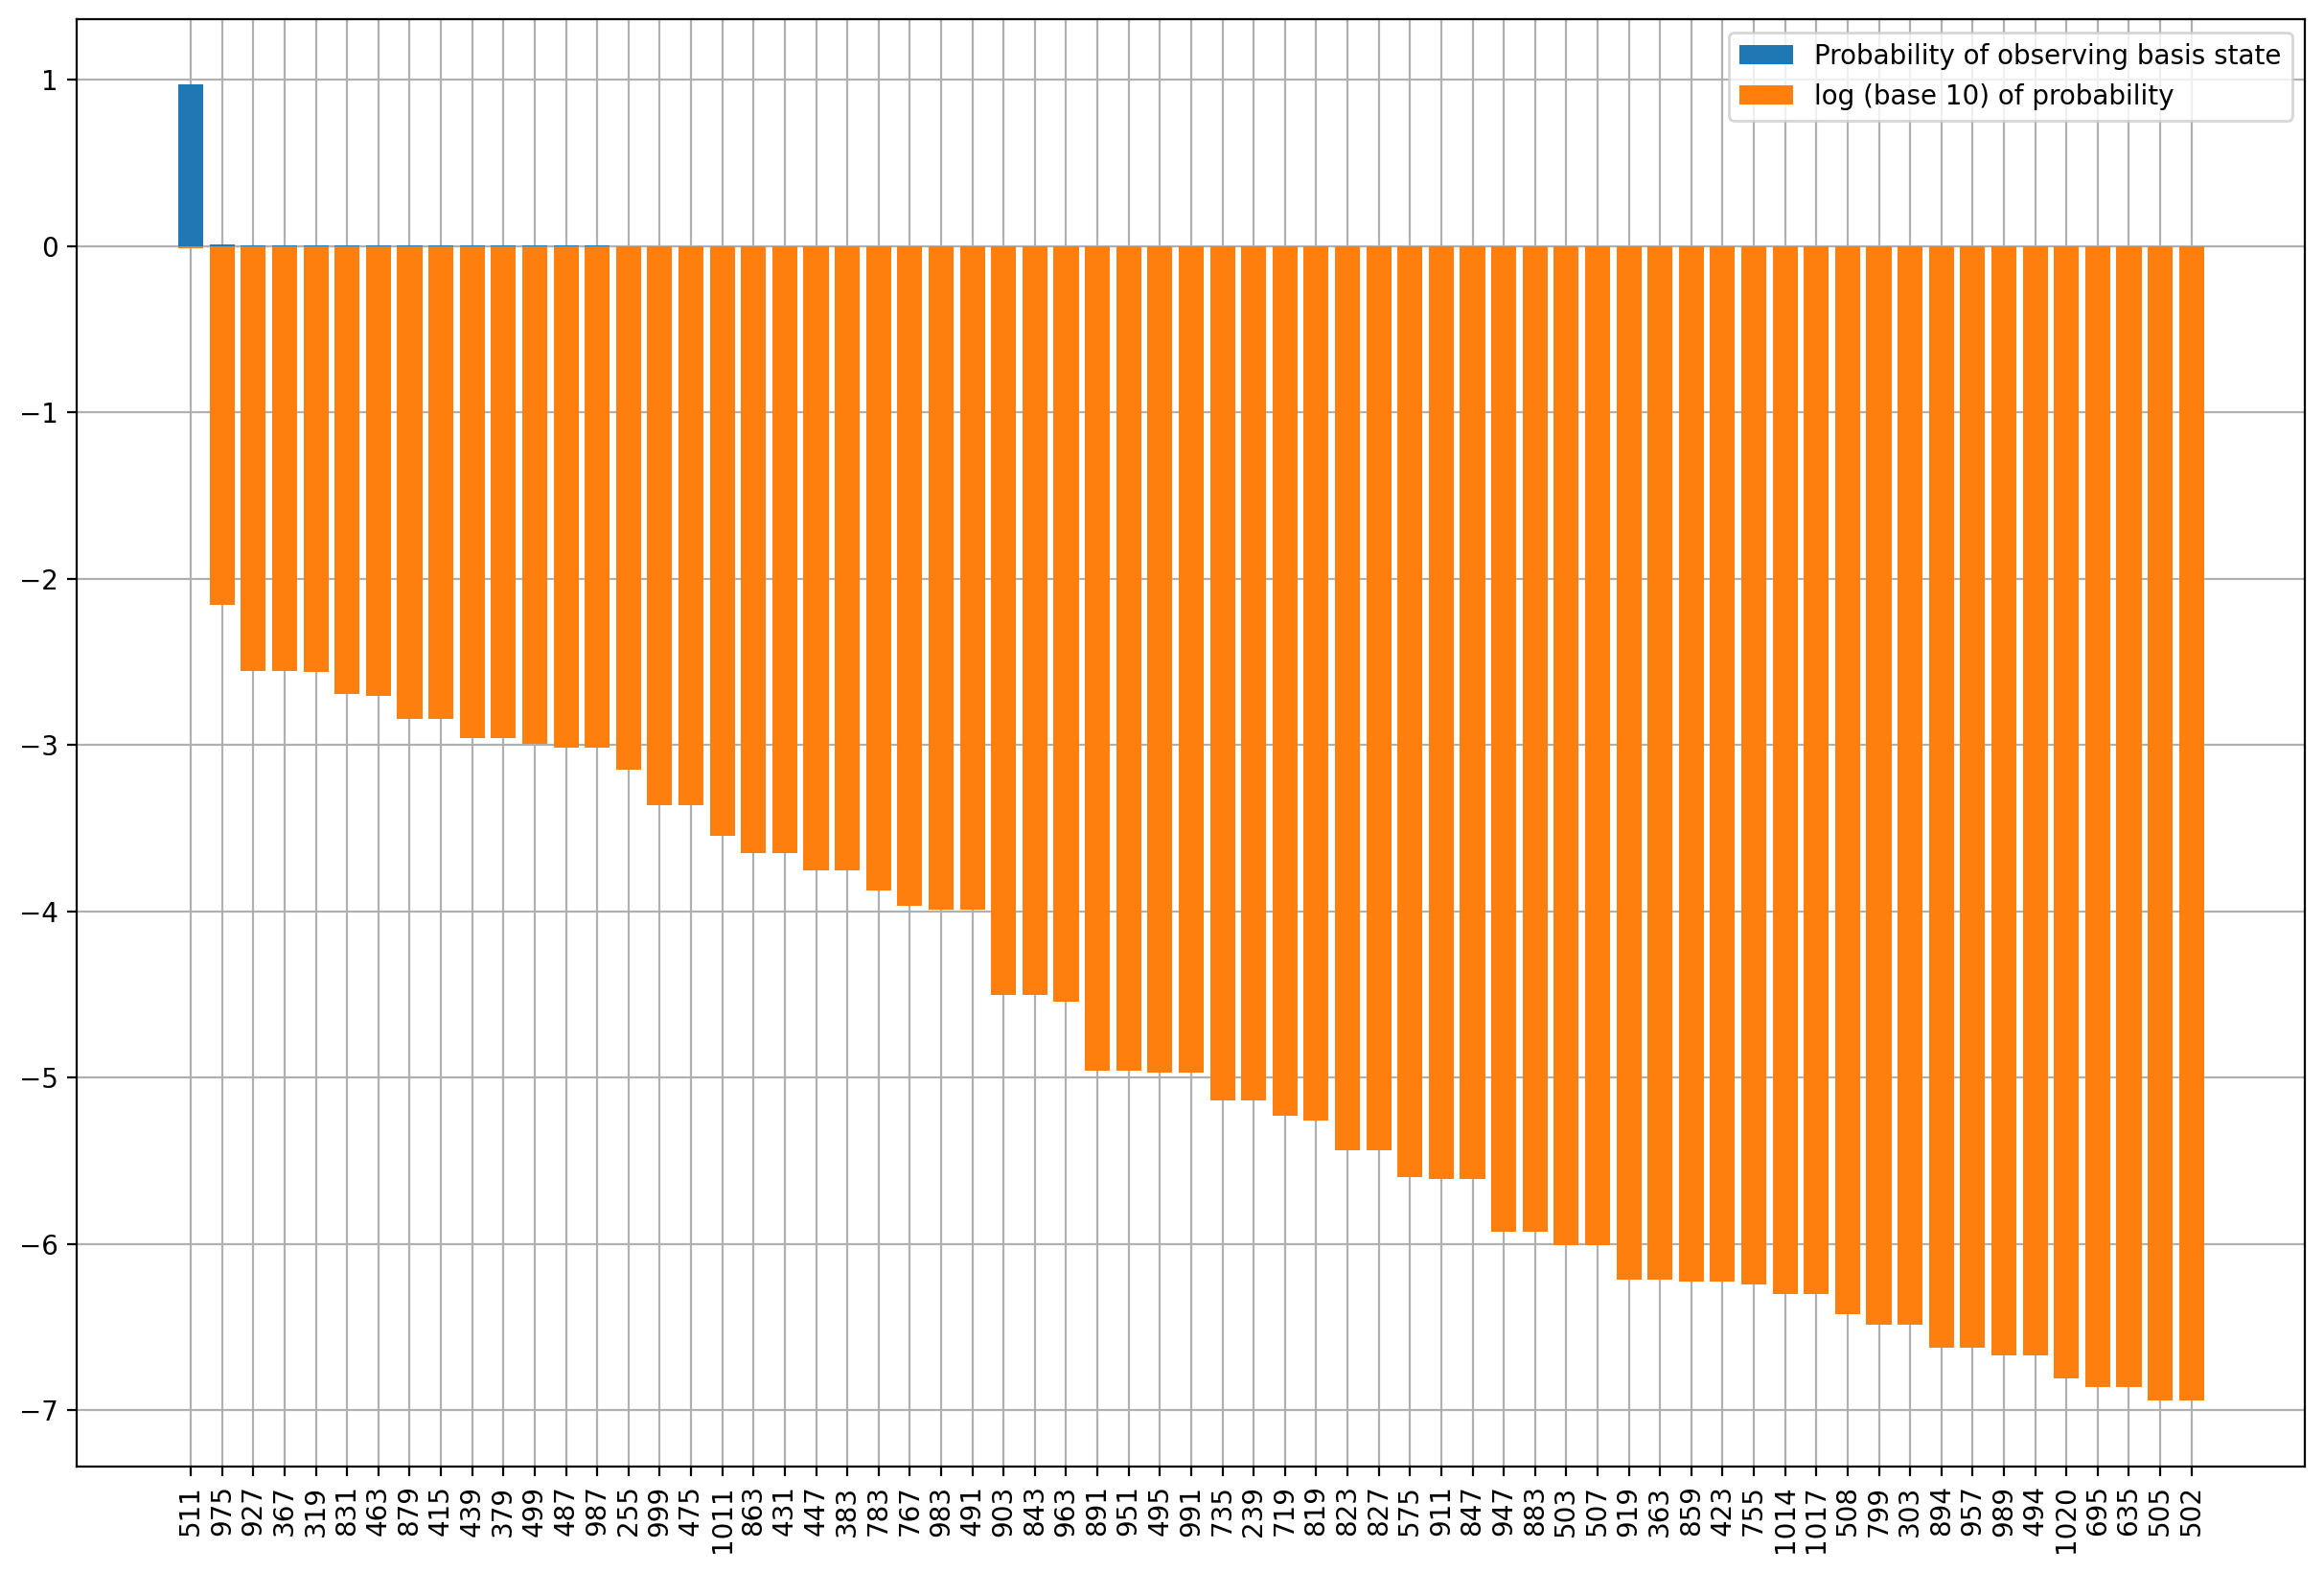

In [16]:
gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())

amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = sorted([(str(index), a) for index, a in enumerate(amp_list) if a > 10**-7], key=lambda x:x[1])
sig_amp_list.reverse()

XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]
Y_log = [np.log10(a) for a in Y]

from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=200)

plt.grid(zorder=0)
plt.bar(X, Y, zorder=2, label='Probability of observing basis state')
plt.bar(X, Y_log, zorder=3, label = 'log (base 10) of probability')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [17]:
sorted(qmap_expect, key=lambda x:x[0])

[[(-83.87422390061549+0j), [(495, '0111101111'), (511, '0111111111')]],
 [(-83.30638268868681+0j), [(431, '0110101111'), (447, '0110111111')]],
 [(-83.03663302190607+0j), [(975, '1111001111'), (991, '1111011111')]],
 [(-82.57360408469224+0j), [(399, '0110001111'), (415, '0110011111')]],
 [(-82.48060531337028+0j), [(911, '1110001111'), (927, '1110011111')]],
 [(-81.49537082519426+0j), [(943, '1110101111'), (959, '1110111111')]],
 [(-81.48188529598328+0j), [(463, '0111001111'), (479, '0111011111')]],
 [(-78.07900070517773+0j), [(1007, '1111101111'), (1023, '1111111111')]]]

['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'] [9, 8, 7, 6, 4, 3, 2, 1, 0]


KeyboardInterrupt: 

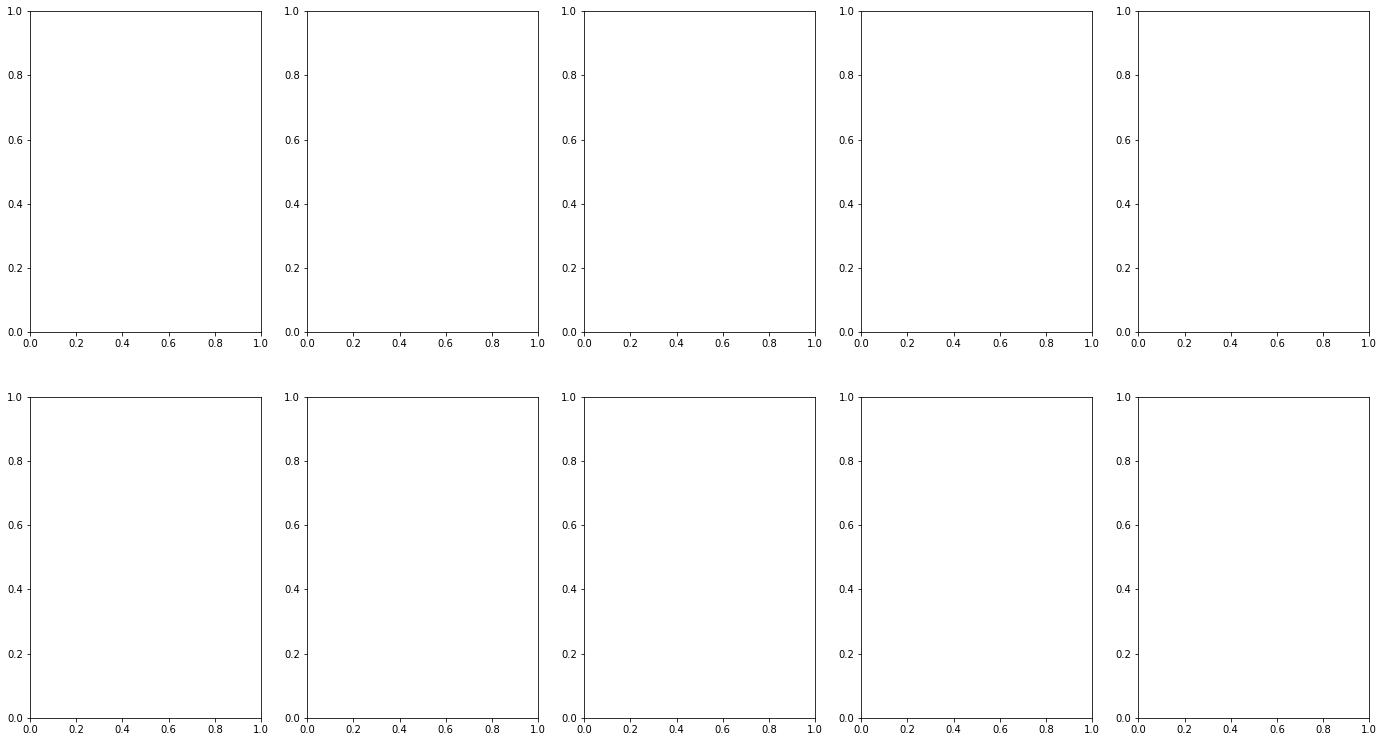

In [11]:
#take expectation value algebraically
from matplotlib import pyplot as plt
molecule='H2O'
shots=20
initial_state = '0111101111'

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (24,13))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]
grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(index, 9))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context, num_qubits)

    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = eig.random_vector(2**len(removed_index))
        rand_vec = sorted([eig.random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)

    #amps=[random_vector(len(eigenstate_indices)) for i in range(shots)]
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                                  r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
                                                                  Z_indices=Z_indices)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    #axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index-9))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [ ]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10
initial_state = '0111101111'
molecule = 'H2O'

removed_index = [0, 3, 4]
removed_generators = [generators[i] for i in removed_index]
Z_indices = [g.find('Z') for g in removed_generators]
print(removed_generators, Z_indices)


new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon, num_qubits)
new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context, num_qubits)

eigenstate_indices = eig.find_eigenstate_indices(initial_state, Z_indices)
print(eigenstate_indices)

prob=0.99999
amps=[]
for i in range(shots):
    amp_1 = [np.sqrt(prob)]
    amp_rest = [np.sqrt(1-prob)*a for a in eig.random_vector(len(eigenstate_indices)-1)]
    amp_1 += amp_rest
    amps.append(amp_1)

X=list(range(1, shots+1))
Y_noncon=[]
Y_context=[]
Y_combined=[]
Y_full=[]

#A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
#A = LinearQubitOperator(A_op, num_qubits)

for p in amps:
    expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                              r1=r1, r2=r2, amps=p, initial_state=initial_state,num_qubits=num_qubits,
                                                              Z_indices=Z_indices)
    total = expect_noncon + expect_context
    #Y_full.append(expect_full)
    Y_noncon.append(expect_noncon)
    Y_context.append(expect_context)
    Y_combined.append(total)
    print(total, total < gs_noncon_energy, p)

#plt.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
#plt.plot(X, Y_context, color='blue', ls='--')
plt.scatter(X, Y_combined, color='black', marker = 'x')
plt.plot(X, Y_combined, color='black', ls='--')
plt.hlines(gs_noncon_energy, 1, shots, color='r')
#plt.hlines(true_gs, 1, shots, color='g')

In [61]:
generators

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

In [67]:
qmap = eig.qubit_map('H2O', num_qubits)

for i in eig.find_eigenstate_indices('0111101111', [0,3,4]):#, include_complement=True, num_qubits=num_qubits, molecule='H2O'):
    print(qmap[i])

[(495, '0111101111'), (511, '0111111111')]
[(1007, '1111101111'), (1023, '1111111111')]
[(431, '0110101111'), (447, '0110111111')]
[(463, '0111001111'), (479, '0111011111')]
[(943, '1110101111'), (959, '1110111111')]
[(975, '1111001111'), (991, '1111011111')]
[(399, '0110001111'), (415, '0110011111')]
[(911, '1110001111'), (927, '1110011111')]


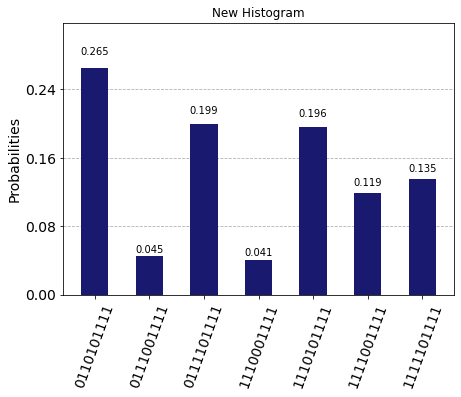

In [87]:
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.algorithms import VQE
from qiskit import Aer

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits)
for q in [0,1,2,3,5,6,7,8]:
    anz.x(q)
anz.barrier()

anz = c_anz.exp_P(p_string='IIIIIIIIIX', circ=anz, rot=np.pi/4)
anz = c_anz.exp_P(p_string='IIIIIIXIII', circ=anz, control=9, rot=np.pi/4)
anz.x(9)
anz = c_anz.exp_P(p_string='IIIIIIXIII', circ=anz, control=9, rot=np.pi/4)
anz.x(9)
anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=9, rot=np.pi/8)
anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=6, rot=np.pi/8)

#ensure +1-eigenstates
anz.cry(2*t1, 5, 4)
anz.x(5)
anz.cry(2*t2, 5, 4)
anz.x(5)
anz.x(4)

anz.measure_all()
#print(anz.draw())
backend = BasicAer.get_backend('qasm_simulator')
job = execute(anz, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

In [94]:
ham_qiskit = qonvert.dict_to_WeightedPauliOperator(ham)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
slsqp = SLSQP(maxiter=5000)

#anz=QuantumCircuit(num_qubits)
#for q in [0,1,2,3,5,6,7,8]:
#    anz.x(q)
#anz.barrier()

#anz = c_anz.exp_P(p_string='IIIIIIXIII', circ=anz, rot=Parameter('a'))
#anz = c_anz.exp_P(p_string='IIIIIXIIIX', circ=anz, control=6, rot=Parameter('b'))
#anz.x(6)
#anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=6, rot=Parameter('c'))
#anz.x(6)
#anz = c_anz.exp_P(p_string='IIIIIIXIII', circ=anz, control=9, rot=Parameter('d'))
#anz.cry(2*t1, 5, 4)
#anz.x(5)
#anz.cry(2*t2, 5, 4)
#anz.x(5)
#anz.x(4)

anz=QuantumCircuit(num_qubits)
for q in [0,1,2,3,5,6,7,8]:
    anz.x(q)
anz.barrier()

anz = c_anz.exp_P(p_string='IIIIIIIIIX', circ=anz, rot=Parameter('a'))

anz = c_anz.exp_P(p_string='IIIIIIXIII', circ=anz, control=9, rot=Parameter('b'))
anz.x(9)
anz = c_anz.exp_P(p_string='IIIIIIXIII', circ=anz, control=9, rot=Parameter('c'))
anz.x(9)

anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=9, rot=Parameter('d'))
anz.x(9)
anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=9, rot=Parameter('e'))
anz.x(9)
anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=6, rot=Parameter('f'))
anz.x(6)
anz = c_anz.exp_P(p_string='IIIIIXIIII', circ=anz, control=6, rot=Parameter('g'))
anz.x(6)

#ensure +1-eigenstates
anz.cry(2*t1, 5, 4)
anz.x(5)
anz.cry(2*t2, 5, 4)
anz.x(5)
anz.x(4)

vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
vqe_result = vqe_run.optimal_value# + shift

print(vqe_result<gs_noncon_energy, '|', 'VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy, '|', 'True Ground State:', true_gs)
print(anz.draw())

True | VQE: -83.87585727076664 | Noncontextual Ground State: -83.87422390061549 | True Ground State: -83.92870248174707
     ┌───┐ ░                       ░                       ░                 »
q_0: ┤ X ├─░───────────────────────░───────────────────────░─────────────────»
     ├───┤ ░                       ░                       ░                 »
q_1: ┤ X ├─░───────────────────────░───────────────────────░─────────────────»
     ├───┤ ░                       ░                       ░                 »
q_2: ┤ X ├─░───────────────────────░───────────────────────░─────────────────»
     ├───┤ ░                       ░                       ░                 »
q_3: ┤ X ├─░───────────────────────░───────────────────────░─────────────────»
     └───┘ ░                       ░                       ░                 »
q_4: ──────░───────────────────────░───────────────────────░─────────────────»
     ┌───┐ ░                       ░                       ░                 »
q_5: ┤ X ├─

In [91]:
print(vqe_run)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 440,
    'eigenstate': array([0.00000000e+00+0.j        , 0.00000000e+00+0.j        ,
       0.00000000e+00+0.j        , ..., 0.00000000e+00+0.j        ,
       0.00000000e+00+0.j        , 8.66099977e-18+0.00010189j]),
    'eigenvalue': -83.88037246525053,
    'optimal_parameters': {   Parameter(c): -6.215323472828116,
                              Parameter(b): -0.7011088393215525,
                              Parameter(a): -3.1417836066181994,
                              Parameter(d): -3.9385117374473944,
                              Parameter(k): 5.468892431037617,
                              Parameter(f): 4.70932076081422,
                              Parameter(l): -2.789781633528512,
                              Parameter(j): -5.526783315748133,
                              Parameter(h): 4.94404016773897,
                              Parameter(m): -1.2207463706946273,
                              Parameter

In [135]:
for i in eig.find_eigenstate_indices('0111101111', [0,3,4]):
    psi = eig.add_eigenstate(molecule='H2O', r1=r1, r2=r2, index=i, theta=0, num_qubits=num_qubits)
    expect = eig.expectation(ham_q, psi, num_qubits)
    print(expect, qmap[i])

(-83.87422390061549+0j) [(495, '0111101111'), (511, '0111111111')]
(-78.07900070517773+0j) [(1007, '1111101111'), (1023, '1111111111')]
(-83.30638268868681+0j) [(431, '0110101111'), (447, '0110111111')]
(-81.48188529598328+0j) [(463, '0111001111'), (479, '0111011111')]
(-81.49537082519426+0j) [(943, '1110101111'), (959, '1110111111')]
(-83.03663302190607+0j) [(975, '1111001111'), (991, '1111011111')]
(-82.57360408469224+0j) [(399, '0110001111'), (415, '0110011111')]
(-82.48060531337028+0j) [(911, '1110001111'), (927, '1110011111')]
